In [33]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
reload(brownian)
reload(time_series)
from time_series import find_files, find_ders, Collection, bin_func

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# New function definitions

In [34]:
def sort_fnames(fnames, include=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

# Directory structure

In [35]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20211215']

In [36]:
# Select a date
date_der_index = -1
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20211215/bead1']

In [37]:
# Select a bead
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20211215/bead1/pulse1']

In [38]:
# Select an experiment
experiment_der_index = 0
fnames = find_files(experiment_ders[experiment_der_index])
fnames

['/data/brownian/20211215/bead1/pulse1/iter_8.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_9.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_5.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_7.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_4.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_10.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_1.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_3.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_6.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_2.tdms']

In [39]:
sort_fnames(fnames, include=[1,3])

['/data/brownian/20211215/bead1/pulse1/iter_1.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_3.tdms']

# PSD calibration

In [53]:
import brownian
import time_series
reload(brownian)
reload(time_series)
from time_series import find_files, find_ders, Collection, bin_func
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

0 [2.02093828e-05 1.33413346e+03 6.42410492e+05 2.94056893e+02]
1 [2.16624316e-05 1.39412759e+03 6.64603510e+05 2.94056664e+02]
2 [2.23693901e-05 1.41984200e+03 6.63648340e+05 2.94044490e+02]
3 [2.17581047e-05 1.41084095e+03 6.44733886e+05 2.94025260e+02]
4 [2.12871713e-05 1.37005951e+03 6.24427868e+05 2.94038118e+02]
5 [2.19268422e-05 1.41187545e+03 6.38982872e+05 2.94027627e+02]
6 [2.21941592e-05 1.43663004e+03 6.65462522e+05 2.94008778e+02]
7 [2.22427920e-05 1.42823641e+03 6.37657454e+05 2.93995540e+02]
8 [2.16933578e-05 1.40883454e+03 6.41071866e+05 2.93999260e+02]
9 [2.17375966e-05 1.38677005e+03 6.31530324e+05 2.93974596e+02]


(1e-25, 1.0647510264775781e-18)

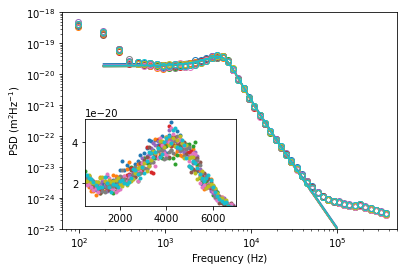

In [42]:
fmin = 5e2
fmax = 4e4
bin_average_Npts = 32
cutoff = 500e3

fig, ax = plt.subplots(1,1, figsize=(6,4))
axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)


krhoATs = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    color = f"C{fnamei}"
    C = Collection(fname)
    T = np.mean(C.Ts) + 273.15
    C.set_collection("X")
    C.apply("detrend", inplace=True, mode="constant")
    C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=bin_average_Npts, inplace=True)
    
    freq, psd = C.average("PSD", taumax=100e-3)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    krhoA = get_krhoA(*abc, C.R, T)
    k, rho, A = krhoA
    krhoAT = np.r_[krhoA, T]
    krhoATs.append(krhoAT)    
    print(fnamei, krhoAT)
    psd /= A*A
    
    logfreq  = logbin_func(freq, Npts=20)
    logpsd  = logbin_func(psd, Npts=20)
    logmask = np.logical_and(logfreq>fmin, logfreq<fmax)
    ax.loglog(logfreq, logpsd, mec=color, mfc="none", marker="o", ls="none")
    line_mask = np.logical_and(freq>100, freq<1e5)
    ax.loglog(freq[line_mask], psd_func(freq, k, rho, T, C.R)[line_mask], c=color)
    axins.plot(freq, psd, c=color, marker=".", ls="none")
    axins.set_xlim(500, 7000)
    axins.set_ylim(0.9e-20, 5.1e-20)
    
krhoATs = np.array(krhoATs)
ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
ax.set_xlabel(r"Frequency (Hz)")
ax.set_xlim(right=cutoff)
ax.set_ylim(bottom=1e-25)

k : 21.70812284515143 0.5862004316384712 2.7003736611404
rho : 1400.1350007715912 28.833190365362412 2.059315019585463
A : 1.5499893519442831 0.03259523504305466 2.1029328364203077
T : 20.872722357946856 0.026193345345563154 0.12549079557698703


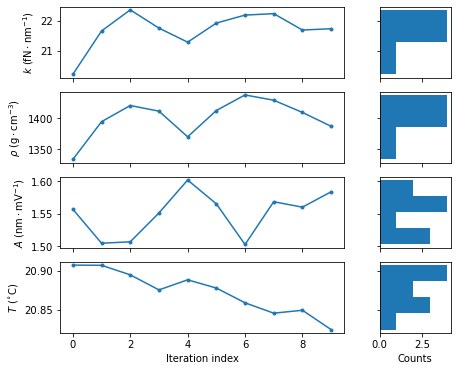

In [43]:
fig, axs = plt.subplots(4,2, figsize=(7, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "A", "T"]):
    vals = krhoATs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="A":
        vals = 1/vals * 1e9/1e3
    if param == "T":
        vals = vals -273.15
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
    


# 100-trial time-domain averages

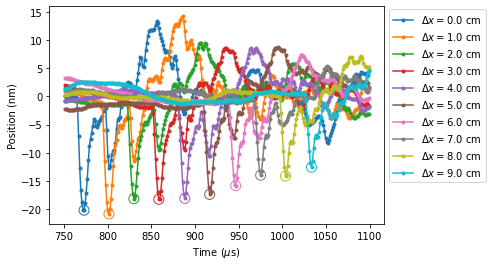

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4))


Npts = 32
tmin = 750e-6
tmax = 1100e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    cal = 1 / krhoATs[fnamei, -2]
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("X", bin_average=Npts)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    ax.plot(1e6*tm, 1e9*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos)
    ax.scatter([1e6*tpeak], [1e9*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

ax.set_ylabel("Position (nm)")
ax.set_xlabel(r"Time ($\mu$s)");

Text(0, 0.5, 'velocity ${\\rm (mm s^{-1})}$')

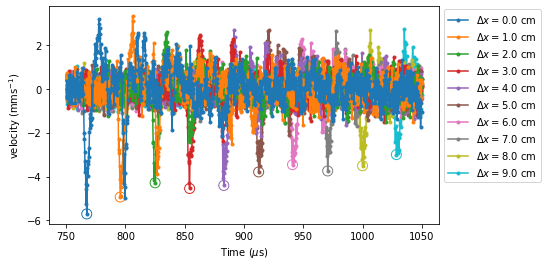

In [98]:
fig, ax = plt.subplots(1,1, figsize=(7,4))


Npts = 16
tmin = 750e-6
tmax = 1050e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    cal = 1 / krhoATs[fnamei, -2]
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("VX", bin_average=Npts/2)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    ax.plot(1e6*tm, 1e3*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos, zorder=len(fnames)-fnamei)
    ax.scatter([1e6*tpeak], [1e3*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

#ax.set_ylabel("Velocity ${\rm (mm \cdot s^{-1})}$")
ax.set_xlabel(r"Time ($\mu$s)")
ax.set_ylabel(r"velocity ${\rm (mm s^{-1})}$")

342.6350901655324


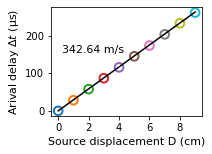

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.))
def slope(x, m):
    return m*x

def slope_quad(x, a, b):
    return a*x + b*x*x


popt, pcov = curve_fit(slope, poses, delta_ts, p0=[1/344.0], bounds=[(0,), (np.inf)])
speed = 1 / popt[0]
print(speed*1e-2)
plt.plot(poses, 1e6*poses/speed, c="k")
#popt2, pcov2 = curve_fit(slope_quad, poses, delta_ts, p0=[1/344.0, 0], bounds=[(0,0), (np.inf, np.inf)])
#plt.plot(poses, 1e6*poses*(popt2[0]+poses*popt2[1]), c="k", ls="--")
for fnamei, (pos, dt) in enumerate(zip(poses, delta_ts)):
    color = f"C{fnamei}"
    ax.scatter([pos], [1e6*dt],  marker="o", ec=color, fc="none", s=75, lw=2)
ax.set_ylabel(r"Arival delay $\Delta t$ (${\rm \mu}$s)", size=11)
ax.set_xlabel("Source displacement D (cm)", size=11)
ax.text(0.25, 155, f"{round(speed*1e-2, 2)} m/s", fontsize=11)
plt.savefig("figures/wave_speed.png", bbox_inches="tight", dpi=600)

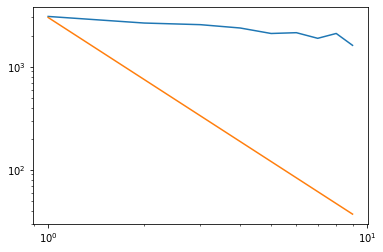

In [27]:
plt.loglog(poses[1:], -np.array(Vpeaks[1:]))
plt.loglog(poses[1:], 3000/poses[1:]**2)

# Single Shot time-domain

In [278]:
import acoustic_entrainment
import brownian
import time_series
import constants
reload(acoustic_entrainment)
reload(brownian)
reload(time_series)
reload(constants)
from time_series import Collection
from acoustic_entrainment import VelocityResponse

fnamei = 0
c0 = 342.64
fname = sort_fnames(fnames)[fnamei]
C = Collection(fname)
k, rho, A, T = krhoATs[fnamei]
bead_cal = 1/A
R = C.R
response = VelocityResponse(R=R, rho=rho, T=T, c0=c0, k=k)

In [279]:
-5e-3/c0

-1.4592575297688536e-05

520833.3333333334
520833.3333333334
520833.3333333334
520833.3333333334


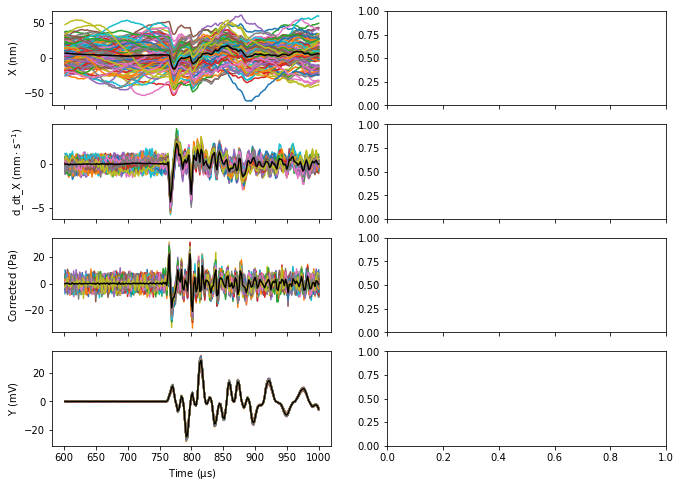

In [463]:
fig, axs = plt.subplots(4,2, figsize=(11, 8), sharex="col")
plot_tmin, plot_tmax = 600e-6, 1000e-6
tpad = 0
mic_tshift = 4e-3/c0

correction_tmin, correction_tmax = plot_tmin - tpad, plot_tmax + tpad
Cx = Collection(fname)
Cv = Collection(fname)
Cp = Collection(fname)
Cmic = Collection(fname)
Cs = [Cx, Cv, Cp, Cmic]
units = ["nm", "mm_s", "Pa", "mV"]
for C in Cs:
    if C == Cmic:
        ch ="Y"
        cal = -1.0
    else:
        ch = "X"
        cal = bead_cal
    C.set_collection(ch)
    C.apply("calibrate", cal=cal, inplace=True)
    C.apply("detrend", mode="constant", inplace=True)
    #C.apply("lowpass", cutoff=300e3, order=3, inplace=True)
    Npts = cutoff/C.r
    C.apply("bin_average", Npts=50, inplace=True)
    print(C.r)
    
for C in [Cv, Cp]:
    C.differentiate()
    C.apply("lowpass", cutoff=250e3, order=3, inplace=True)

Cp.apply_func(response.correct_signal, tmin=correction_tmin, tmax=correction_tmax,
              correction="bassetbound", window="boxcar", impedance="cyl", r0=5e-2)

for Ci, C in enumerate(Cs):
    C.aggrigate()
    if C == Cmic:
        C.agg.t -= mic_tshift
    C.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=axs[Ci, 0], tunit="us", unit=units[Ci], c="k", zorder=1000)


for Ci, C in enumerate(Cs):
    for D in C.collection[:-1]:
        if C == Cmic:
            D.t -= mic_tshift
        D.plot(tmin=plot_tmin, tmax=plot_tmax, ax=axs[Ci, 0], tunit="us", unit=units[Ci])
    axs[Ci, 0].label_outer()

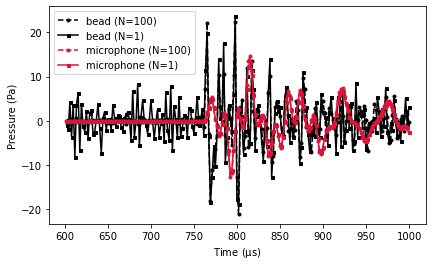

In [464]:
fig, ax = plt.subplots(1,1, figsize=(2*3.375, 4))
Cp.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit="Pa",
            marker="o", ms=3, c="k", ls="--", label="bead (N=100)")
Cp.collection[10].plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit="Pa",
                       marker="s", ms=3, c="k", ls="-", label="bead (N=1)")

Cmic.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit=20e-4,
              marker="o", ms=3, c="crimson", ls="--", label="microphone (N=100)")
Cmic.collection[10].plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit=20e-4, 
                         marker="s", ms=3, c="crimson", ls="-", label="microphone (N=1)")
ax.set_ylabel("Pressure (Pa)")
plt.legend()
#plt.savefig("figures/20kHz-microphone_bead_compare.pdf", bbox_inches="tight")

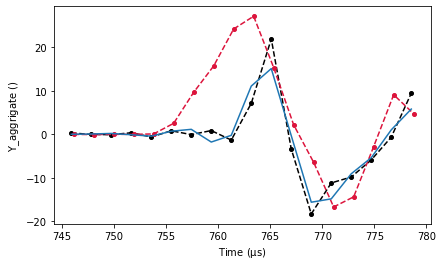

In [265]:
fig, ax = plt.subplots(1,1, figsize=(2*3.375, 4))
Cp.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit="Pa",
            marker="o", ms=4, c="k", ls="--", label="bead (N=100)")
Cmic.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit=4e-4,
              marker="o", ms=4, c="crimson", ls="--", label="microphone (N=100)")

pt_lp, p_lp = Cp.agg.lowpass(cutoff=150e3)
mask = np.logical_and(pt_lp>plot_tmin, pt_lp<plot_tmax)
ax.plot(pt_lp[mask]*1e6, p_lp[mask])

Text(0, 0.5, 'v ${\\rm (mm ~ s^{-1})}$')

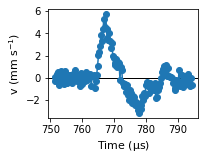

In [313]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.))
ax.plot(tbar*1e6, -xbar*1e3, marker="o")
ax.axhline(0, c="k", lw=1, zorder=0)
ax.set_xlabel(r"Time (${\rm \mu}$s)", size=11)
ax.set_ylabel(r"v ${\rm (mm ~ s^{-1})}$", size=11)
#plt.savefig("figures/100-avg_velocity-pulse.png", bbox_inches="tight", dpi=600)

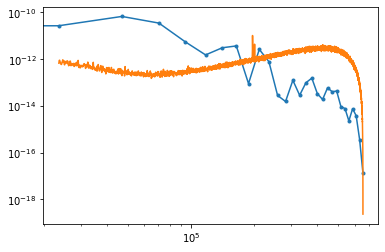

In [90]:
freq_pulse, psd_pulse, N = PSD(xbar, 1/C.r)
freq, psd = C.average("PSD")

plt.loglog(freq_pulse, psd_pulse, marker=".")
plt.loglog(freq[freq>freq_pulse[1]], psd[freq>freq_pulse[1]]*cal*cal)

In [153]:
(5/C.r)

2.800000000000003e-06

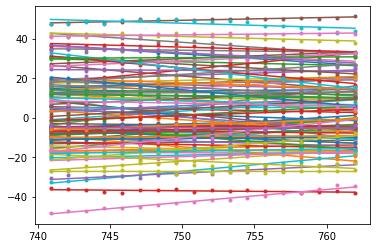

In [32]:
fnamei = 0
tmin, tmax = 740e-6, 763e-6
fname = sort_fnames(fnames)[fnamei]
C = Collection(fname)
cal = 1 / krhoATs[fnamei, -2]
m = 4 * np.pi * krhoATs[fnamei, 1] * C.R**3 / 3
k = krhoATs[fnamei, 0]

C.set_collection("X", bin_average=Npts)
C.apply("detrend", mode="constant", inplace=True)
xvbars = []
res = []
for Di, D in enumerate(C.collection):
    color = f"C{Di}"
    mask = np.logical_and(D.t>tmin, D.t<tmax)
    t, x = D.t[mask], D.x[mask]* cal
    vbar, b  = np.polyfit(t, x, deg=1)
    res.append((x - np.poly1d([vbar, b])(t)))
    xbar = b + vbar*(tmax*tmax-tmin*tmin) / (2*(tmax-tmin))
    xvbars.append([xbar, vbar])
    plt.plot(t*1e6, x*1e9, marker=".", ls="none",  color=color)
    plt.plot(t*1e6, (t*vbar+b)*1e9,  color=color)
    #plt.axhline(xbar*1e9, color=color)
xvbars = np.array(xvbars)
res = np.array([el for r in res for el in r])


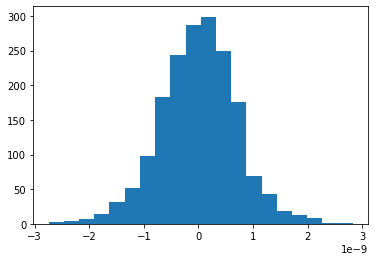

In [33]:
plt.hist(res, bins=20);

In [34]:
E = k * xvbars[:, 0]**2 / 2 + m * xvbars[:, 1]**2 / 2
inds = np.argsort(E)

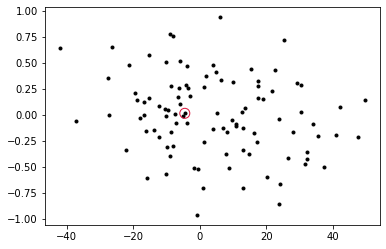

In [35]:
plt.scatter(xvbars[:, 0]*1e9, xvbars[:, 1]*1e3, marker=".", c="k")
plt.scatter([xvbars[inds[0], 0]*1e9], [xvbars[inds[0], 1]*1e3], ec="crimson", fc="none", s=100)

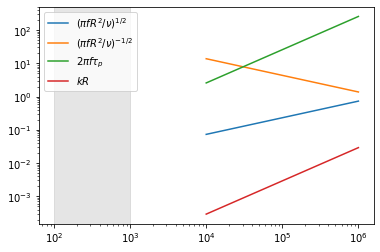

In [413]:
fs = np.geomspace(1e2,1e6, 100)
fs = np.geomspace(1e4, 1e6, 100)
plt.loglog(fs, response.y(fs), label=r"$(\pi f R^2/\nu)^{1/2}$")
plt.loglog(fs, 1/response.y(fs), label=r"$(\pi f R^2/\nu)^{-1/2}$")
plt.loglog(fs, np.pi*2*fs*response.taup, label=r"$2 \pi f \tau_p$")
plt.plot(fs, response.b(fs), label=r"$kR$")
plt.axvspan(100, 1000, color="gray", alpha=0.2)
plt.legend()

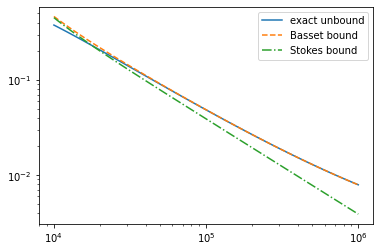

In [414]:
plt.loglog(fs, response.amplitude_ratio_exact(fs), 
           label="exact unbound", ls="-")
plt.loglog(fs, response.amplitude_ratio_bassetbound(fs), 
           label="Basset bound", ls="--")
plt.loglog(fs, response.amplitude_ratio_stokesbound(fs),
           label="Stokes bound", ls="-.")
plt.legend()

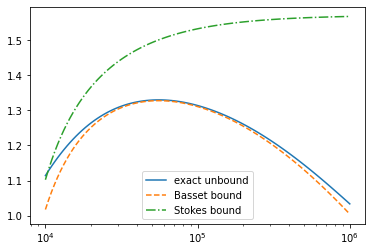

In [415]:
plt.plot(fs, response.phase_exact(fs), 
           label="exact unbound", ls="-")
plt.plot(fs, response.phase_bassetbound(fs), 
           label="Basset bound", ls="--")
plt.plot(fs, response.phase_stokesbound(fs),
           label="Stokes bound", ls="-.")
plt.legend()
plt.xscale("log")
plt.legend()

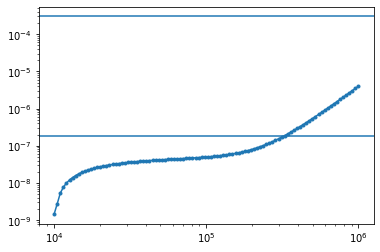

In [420]:
from scipy.integrate import cumulative_trapezoid
from constants import kB
vpsd = (2*np.pi*fs)**2*(psd_func(fs, k, rho, T, C.R) + 3e-25)
cvpsd = cumulative_trapezoid(vpsd, x=fs, initial=vpsd[0]*(fs[1]-fs[0])/2)
plt.axhline(kB * T/response.mass)
cvpsdfreq = fs[:]
plt.loglog(cvpsdfreq, cvpsd, marker=".")
plt.axhline(vel_res0)

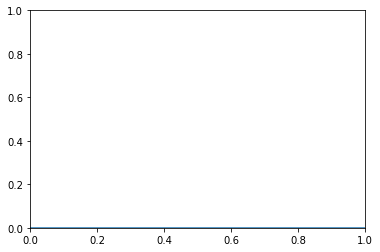

In [432]:
D = Cv.collection[0]
D.NVAR()
vpsd = (2*np.pi*fs)**2*(psd_func(fs, k, rho, T, C.R) + 3e-25)
cvpsd = cumulative_trapezoid(vpsd, x=fs, initial=vpsd[0]*(fs[1]-fs[0])/2)
plt.axhline(kB * T/response.mass)

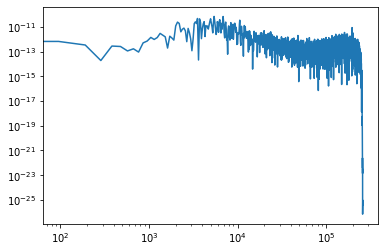

In [433]:
tau, nvar, Nnvar = D.NVAR()
freq, psd, Npsd = D.PSD()
plt.loglog(freq, psd)


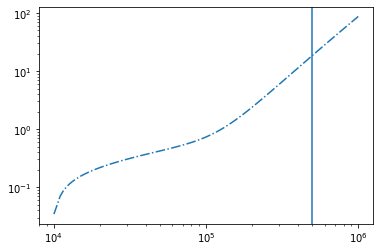

In [418]:
pos_res = 3e-10
#pos_res = 20e-15
time_res = 1e-6
Z = response.rho_fluid*response.c0
vel_res0 = pos_res / time_res

pr = Z**2*vpsd/response.amplitude_ratio_bassetbound(fs)**2
pr0 = (Z*vel_res0/response.amplitude_ratio_bassetbound(fs))**2

cpr = np.sqrt(cumulative_trapezoid(pr, x=fs, initial=pr[0]*(fs[1]-fs[0])/2))
cpr0 = np.sqrt(cumulative_trapezoid(pr0, x=fs, initial=pr0[0]*(fs[1]-fs[0])/2))
plt.loglog(fs, cpr,
           label="Basset bound", ls="-.")
#plt.loglog(fs, cpr0)
plt.axvline(1/(2*time_res))

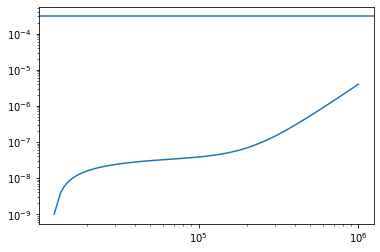

In [407]:
plt.loglog(fs, cvpsd)
plt.axhline(vel_res0)

In [408]:
vel_res0

0.00030000000000000003

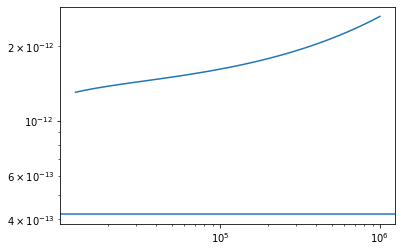

In [409]:
mass = 4/3 * np.pi * rho * R**3
pressure = 1

vf = pressure /(response.rho_fluid*response.c0)
plt.loglog(fs, mass * vf*2*np.pi*fs*response.amplitude_ratio_exact(fs), 
           label="exact", ls="-")

plt.axhline(21e-6*20e-9)

In [410]:
vel_res/bead_cal

array([0.05941599, 0.06521287, 0.07157618, 0.07856156, 0.08623019,
       0.0946494 , 0.10389329, 0.11404351, 0.12519004, 0.13743218,
       0.15087961, 0.1656536 , 0.18188848, 0.19973328, 0.2193537 ,
       0.24093441, 0.26468184, 0.2908275 , 0.31963205, 0.35139031,
       0.38643742, 0.42515659, 0.46798887, 0.51544554, 0.56812394,
       0.6267279 , 0.69209409, 0.76522603, 0.8473382 , 0.93991247,
       1.04476922, 1.16415367, 1.30083239, 1.45818002, 1.64019985,
       1.85133579, 2.09574485, 2.37532761, 2.68527163, 3.00582939,
       3.29231569, 3.4758433 , 3.49437982, 3.34079227, 3.06933546,
       2.75118468, 2.43678981, 2.15026936, 1.89869887, 1.68108342,
       1.49351152, 1.33151553, 1.19098062, 1.06840784, 0.96092108,
       0.86618813, 0.78232475, 0.70780673, 0.6413972 , 0.58208931,
       0.52906246, 0.48164973, 0.43931413, 0.40163198, 0.36828178,
       0.33903679, 0.31375952, 0.29239565, 0.27496413, 0.2615402 ,
       0.25222915, 0.24713255, 0.24631384, 0.24977421, 0.25744

In [347]:
vel_res0

5.208333333333334e-05